In [4]:
# Colab Setup and Imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration (use GPU if available)
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Epsilon values to test the attack strength
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [5]:
# Model Architecture (Simple CNN for MNIST)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Data Loaders
# We need both training and testing loaders to train the model quickly
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
    batch_size=1, shuffle=True) # Batch size 1 is critical for the FGSM test loop!

# Initialize the model
model = Net().to(device)

In [6]:
# Function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 5 # 5 epochs is fast and sufficient for MNIST

print("Starting quick model training...")
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

# Crucial: Set the model back to evaluation mode for the attack
model.eval()
print("Model training complete and set to evaluation mode.")

Starting quick model training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307600
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.809573
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.884409
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.539094
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.424585
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.543271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.363535
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.502526
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.458167
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.267298
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.478709
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.239304
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.412914
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.485324
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.178266
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.359933
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.433597
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.431680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.964005
Train Epoch: 2 [57600/60000 (

In [7]:
# The Fast Gradient Sign Method (FGSM) implementation
def fgsm_attack(image, epsilon, data_grad):
    """
    Core FGSM formula: perturbed_image = image + epsilon * sign(data_grad)
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel
    perturbed_image = image + epsilon * sign_data_grad

    # Clip the perturbed image to maintain the [0,1] range (crucial for valid images)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [11]:
# Function to test the model under FGSM attack and collect adversarial examples
def test(model, device, test_loader, epsilon):

    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # IMPORTANT: Set requires_grad attribute of tensor to TRUE.
        # This is essential for calculating gradients w.r.t the input data.
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # Get the initial predicted class

        # Only attack if the initial prediction is correct (white-box attack goal)
        if init_pred.item() != target.item():
            continue

        # Calculate the loss (Negative Log Likelihood Loss is used with log_softmax output)
        loss = F.nll_loss(output, target)

        # Zero all existing gradients to prevent accumulation
        model.zero_grad()

        # Calculate gradients of loss w.r.t. the input data
        loss.backward()

        # Collect the gradient (data.grad)
        data_grad = data.grad.data

        # Call the FGSM attack function (defined in Cell 4)
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image (the adversarial example)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # Get the final predicted class

        # Check for attack success
        if final_pred.item() == target.item():
            # Attack failed (model still classified correctly)
            correct += 1

            # Save the clean image for visualization only if epsilon=0
            if epsilon == 0 and len(adv_examples) < 5:
                # Save the original data (since it was correctly classified)
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        else:
            # Attack succeeded! (Model was fooled)
            if len(adv_examples) < 5: # Limit saved adversarial examples to 5
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon value
    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon:.3f}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc:.4f}")

    # Return the accuracy and the collected adversarial examples
    return final_acc, adv_examples

Running attack for different Epsilon values...
Epsilon: 0.000	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.050	Test Accuracy = 7325 / 10000 = 0.7325
Epsilon: 0.100	Test Accuracy = 4227 / 10000 = 0.4227
Epsilon: 0.150	Test Accuracy = 3024 / 10000 = 0.3024
Epsilon: 0.200	Test Accuracy = 2544 / 10000 = 0.2544
Epsilon: 0.250	Test Accuracy = 2264 / 10000 = 0.2264
Epsilon: 0.300	Test Accuracy = 2054 / 10000 = 0.2054


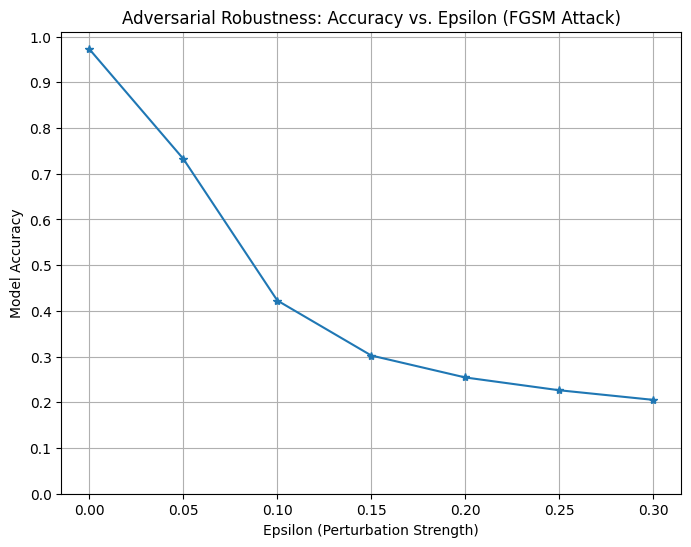

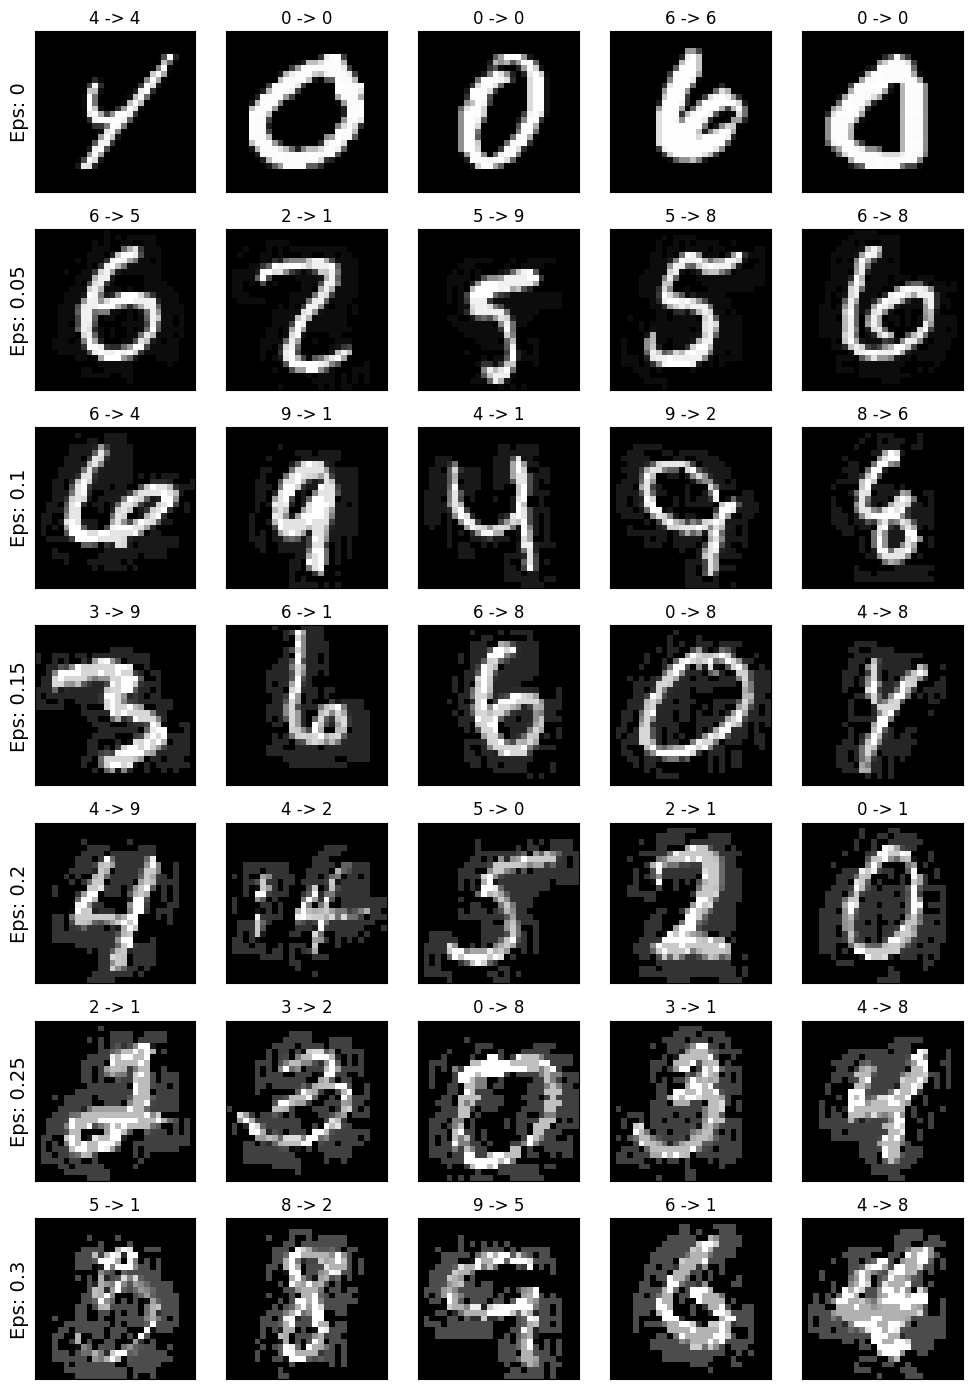


Project Complete: The sharp drop in accuracy confirms the lack of adversarial robustness.
Take screenshots of the plots above and include them in your GitHub README.md!


In [12]:
# Run the attack for all epsilon values
accuracies = []
examples = []

print("Running attack for different Epsilon values...")

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# --- Plot 1: Accuracy vs. Epsilon ---
plt.figure(figsize=(8,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Adversarial Robustness: Accuracy vs. Epsilon (FGSM Attack)")
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Model Accuracy")
plt.grid(True)
plt.show() #

# --- Plot 2: Visualization of Adversarial Examples ---
cnt = 0
plt.figure(figsize=(10, len(epsilons)*2))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)

        orig, adv, ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")

plt.tight_layout()
plt.show() #

print("\nProject Complete: The sharp drop in accuracy confirms the lack of adversarial robustness.")

